In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

In [2]:
artworks_df = pd.read_csv('../01_artwork_clustering/omniart-post-artwork-clustering.csv')

In [3]:
centroids_df = pd.read_csv('../01_artwork_clustering/artwork-centroids.csv')

**1. Features**

In [4]:
artworks_df['cluster'] = 'cluster_' + artworks_df['cluster'].astype(str)

In [5]:
merged_df = pd.merge(artworks_df, centroids_df, left_on='cluster', right_on='name', how='left')

In [6]:
feature_columns = [col for col in centroids_df.columns if col != 'name']

In [7]:
data = merged_df[
    merged_df['decade'].notna()
].dropna(subset=feature_columns)

In [8]:
counts = data['decade'].value_counts()
decades_to_keep = counts[counts >= 2].index
data_filtered = data[data['decade'].isin(decades_to_keep)].copy()

In [9]:
X = data_filtered[feature_columns]

**2. Labels**

In [10]:
y = data_filtered['decade']

**3. Split dataset**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

**4. Classify**

In [12]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [13]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
y_pred = clf.predict(X_test)

**5. Evaluate**

In [15]:
print("Decade Classifier Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Decade Classifier Accuracy: 52.45%


In [16]:
print(classification_report(y_test, y_pred, labels=y.unique(), zero_division=0))


              precision    recall  f1-score   support

        2000       0.00      0.00      0.00     13842
        1360       0.00      0.00      0.00       102
        1750       0.00      0.00      0.00       301
        2010       0.52      1.00      0.69     41573
        1640       0.00      0.00      0.00       408
        1720       0.00      0.00      0.00       240
        1730       0.00      0.00      0.00       151
        1460       0.00      0.00      0.00       245
        1870       0.00      0.00      0.00       790
        1440       0.00      0.00      0.00       200
        1470       0.00      0.00      0.00       339
        1830       0.00      0.00      0.00       246
        1540       0.00      0.00      0.00       156
        1670       0.00      0.00      0.00       394
        1790       0.00      0.00      0.00       372
        1740       0.00      0.00      0.00       163
        1550       0.00      0.00      0.00       244
        1560       0.00    

**4.1. Confusion matrix**

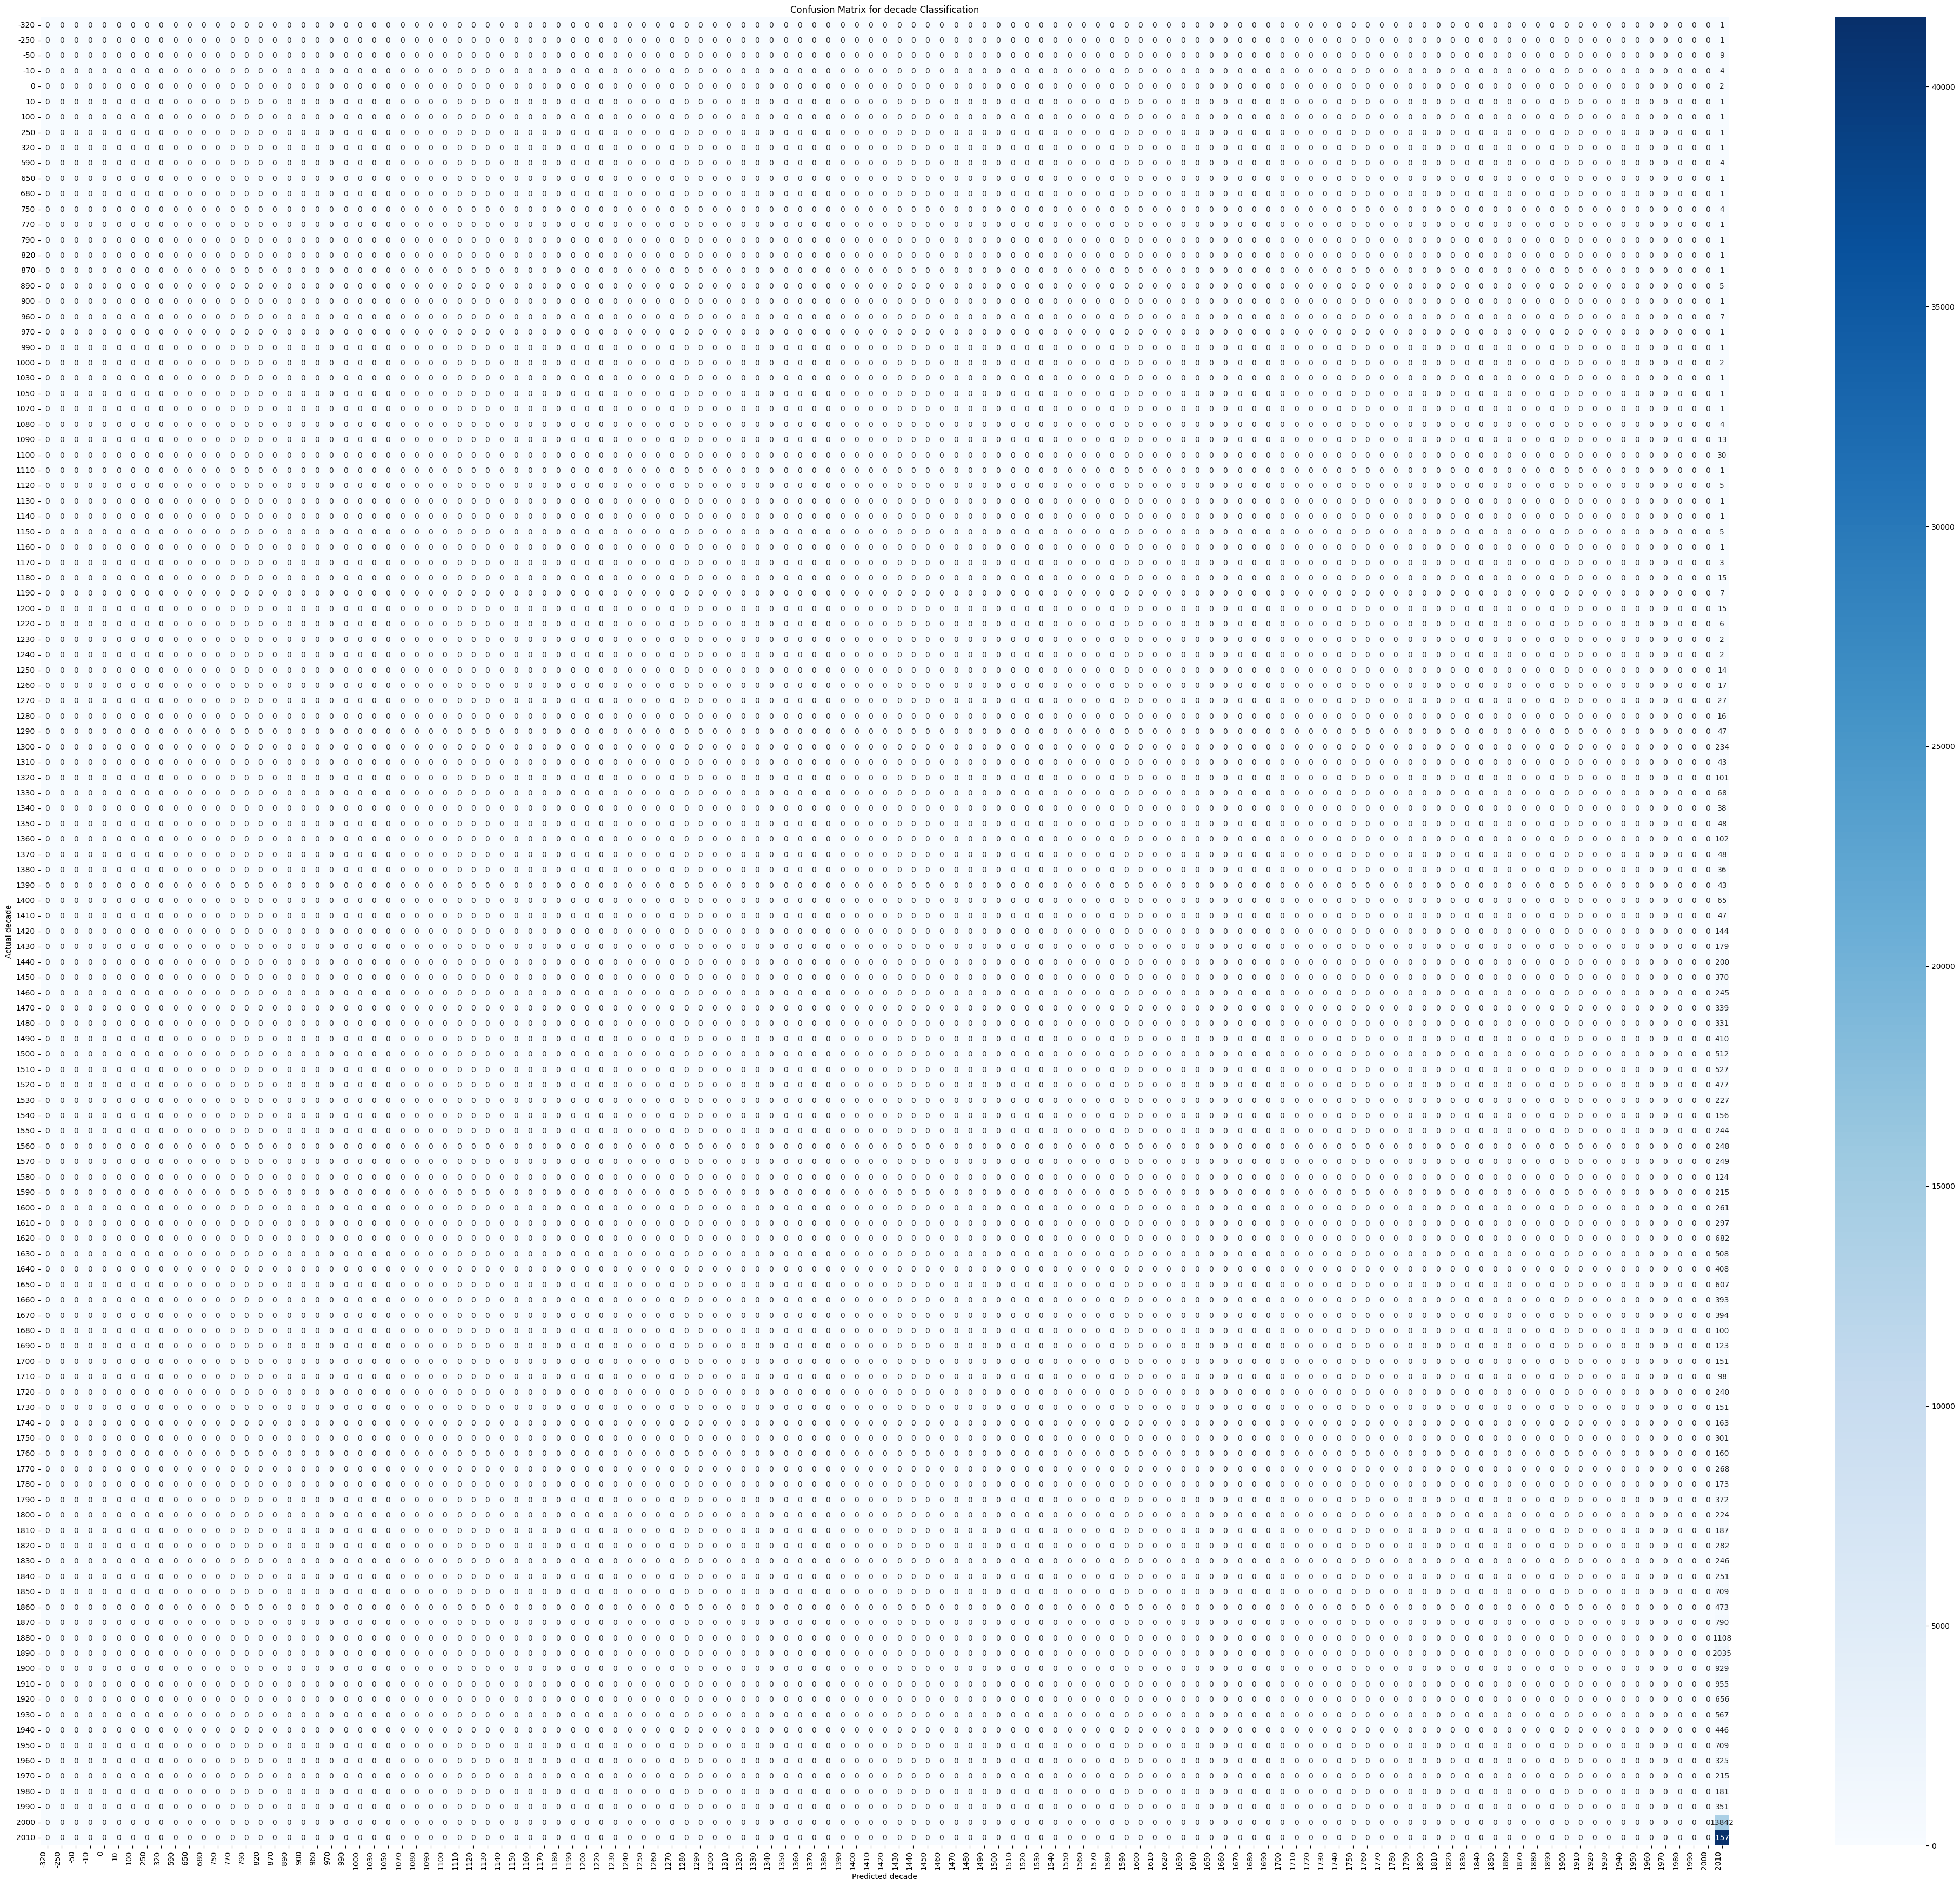

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_labels = clf.classes_

# Generate the confusion matrix for the decade classifier
cm = confusion_matrix(y_test, y_pred, labels=all_labels)

# Plotting the confusion matrix
plt.figure(figsize=(40, 35))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.title('Confusion Matrix for decade Classification')
plt.ylabel('Actual decade')
plt.xlabel('Predicted decade')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

**4.2 Feature importance**

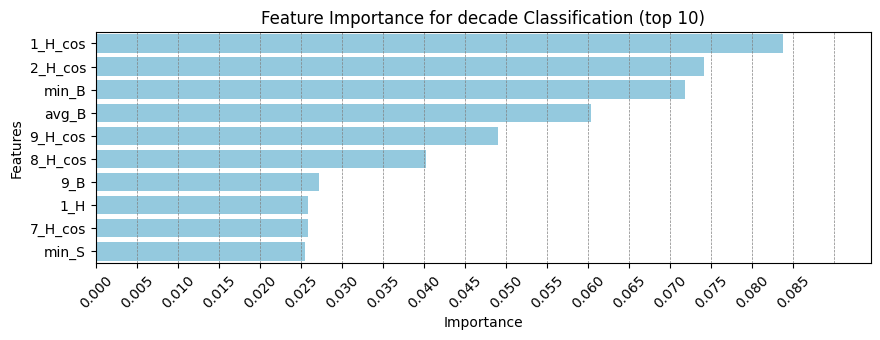

In [18]:
# For the decade classifier (with balanced weights)
feature_importances_s = pd.DataFrame(clf.feature_importances_, 
                                     index = feature_columns, columns=['importance']
                                     ).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 3))
sns.barplot(x=feature_importances_s.importance, y=feature_importances_s.index, color='skyblue')

max_val = feature_importances_s.importance.max()
for x in np.arange(0, max_val + 0.01, 0.005):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
x_ticks = np.arange(0, round(max_val + 0.01, 2), 0.005)
plt.xticks(x_ticks, [f'{tick:.3f}' for tick in x_ticks], rotation=45)
plt.title('Feature Importance for decade Classification (top 10)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

**4.3. AUC value**

The **ROC (Receiver Operating Characteristic) curve** and the **AUC (Area Under the Curve)** are used to evaluate the performance of a **binary classifier**, particularly with respect to **discrimination** — how well it separates positive and negative classes.

1. **What is the ROC Curve?**

The ROC curve plots:

* **True Positive Rate (TPR)** = Sensitivity = Recall =

  $$
  \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
  $$
* **False Positive Rate (FPR)** =

  $$
  \frac{\text{False Positives}}{\text{False Positives + True Negatives}}
  $$

For **many thresholds** applied to predicted probabilities.


3. **What is AUC?**

The AUC is the **area under the ROC curve**, computed using numerical integration.

* AUC = 1 → Perfect classifier
* AUC = 0.5 → No discrimination (random)
* AUC < 0.5 → Worse than random

Mathematically:

If you have the ROC points $(FPR_1, TPR_1), (FPR_2, TPR_2), \ldots$, the AUC is calculated via the **trapezoidal rule**:

$$
\text{AUC} = \sum_{i=1}^{n-1} (FPR_{i+1} - FPR_i) \cdot \frac{TPR_{i+1} + TPR_i}{2}
$$

In [19]:
# Binarize the true labels to use in roc_curve
y_test_binarized = label_binarize(y_test, classes=range(len(all_labels)))
# Get the prediction probabilities for each class
y_score = clf.predict_proba(X_test)
n_classes = y_test_binarized.shape[1]

# Calculate the main confusion matrix to get TP/FP counts
cm = confusion_matrix(y_test, y_pred, labels=all_labels)
    
# Create a dictionary to map decade names to their index for easy lookup
label_map = {label: i for i, label in enumerate(all_labels)}

auc_scores = dict()
tp_counts = dict()
fp_counts = dict()

for i, decade_name in enumerate(all_labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    auc_scores[decade_name] = auc(fpr, tpr)
        
    # Get TP and FP from the confusion matrix
    tp_counts[decade_name] = cm[i, i]
    fp_counts[decade_name] = cm[:, i].sum() - cm[i, i]
        
# Create and display the table
auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Decade', 'AUC Score'])
auc_df['True Positives'] = auc_df['Decade'].map(tp_counts)
auc_df['False Positives'] = auc_df['Decade'].map(fp_counts)
auc_df = auc_df.sort_values(by='AUC Score', ascending=False).reset_index(drop=True)

# Filter the DataFrame to include only rows where at least one TP or FP was recorded
filtered_auc_df = auc_df[(auc_df['True Positives'] > 0) | (auc_df['False Positives'] > 0)]
    
filtered_auc_df = filtered_auc_df.sort_values(by='AUC Score', ascending=False).reset_index(drop=True)
print("AUC Scores for decades with at least one True or False Positive:")
print(filtered_auc_df.to_string())

/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

AUC Scores for decades with at least one True or False Positive:
   Decade  AUC Score  True Positives  False Positives
0    2010        NaN           41573            37688


/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


**4.4 t-SNE**

In [22]:
# Reduce dimensionality of the test features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_test_2d = tsne.fit_transform(X_test)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_test_2d, columns=['tsne1', 'tsne2'])
plot_df['true_decade'] = y_test
plot_df['predicted_decade'] = y_pred
    
# Identify the top 10 decades that actually got predictions
predicted_decades_counts = pd.Series(y_pred).value_counts()
top_10_predicted_decades = predicted_decades_counts.nlargest(10).index.tolist()

# Create a separate figure for each of the top 10 decades
for decade in top_10_predicted_decades:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(f't-SNE Visualization for: {decade}', fontsize=20)
        
    # --- Left Plot: Ground Truth ---
    ax1.set_title('Ground Truth', fontsize=16)
    # Plot all data points in a light gray as a background
    ax1.scatter(plot_df['tsne1'], plot_df['tsne2'], color='lightgray', s=15, alpha=0.3)
    # Highlight points where the TRUE decade is the current one
    true_decade_data = plot_df[plot_df['true_decade'] == decade]
    ax1.scatter(true_decade_data['tsne1'], true_decade_data['tsne2'], color='skyblue', s=40, label=f'Actually {decade}')
    ax1.legend()
    ax1.set_xticks([])
    ax1.set_yticks([])

    # --- Right Plot: Model Predictions ---
    ax2.set_title('Model Predictions', fontsize=16)
    # Plot all data points in a light gray as a background
    ax2.scatter(plot_df['tsne1'], plot_df['tsne2'], color='lightgray', s=15, alpha=0.3)
    # Highlight points where the PREDICTED decade is the current one
    predicted_as_decade = plot_df[plot_df['predicted_decade'] == decade]
    ax2.scatter(predicted_as_decade['tsne1'], predicted_as_decade['tsne2'], color='lightpink', s=40, label=f'Predicted as {decade}')
    ax2.legend()
    ax2.set_xticks([])
    ax2.set_yticks([])

    filename = f"images/full_{decade}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    print(f"Saved figure as: {filename}")
    plt.close(fig)
        
    plt.show()

/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Saved figure as: images/full_2010.png


In [21]:
# Create a DataFrame of incorrect predictions
incorrect_predictions = X_test[y_test != y_pred].copy()
incorrect_predictions['true_decade'] = y_test[y_test != y_pred]
incorrect_predictions['predicted_decade'] = y_pred[y_test != y_pred]

print(f"\nNumber of incorrect predictions: {len(incorrect_predictions)}")
print("\nMost common misclassifications:")
print(incorrect_predictions.groupby(['true_decade', 'predicted_decade']).size().sort_values(ascending=False).head(20))


Number of incorrect predictions: 37688

Most common misclassifications:
true_decade  predicted_decade
2000         2010                13842
1890         2010                 2035
1880         2010                 1108
1910         2010                  955
1900         2010                  929
1870         2010                  790
1950         2010                  709
1850         2010                  709
1620         2010                  682
1920         2010                  656
1650         2010                  607
1930         2010                  567
1510         2010                  527
1500         2010                  512
1630         2010                  508
1520         2010                  477
1860         2010                  473
1940         2010                  446
1490         2010                  410
1640         2010                  408
dtype: int64
